Imports aus der Vorlesung genommen (nicht sicher ob wir alles brauchen)

In [274]:
import os
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, find_peaks, peak_widths, peak_prominences
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


Daten laden

In [275]:
# Laden aller Daten aus dem Ordner: 'csv_data'
def load_csv_data(folder_name):
    data = {}
    csv_folder = os.path.join(os.getcwd(), folder_name)

    if not os.path.exists(csv_folder):
        print(f"Error: The folder '{csv_folder}' was not found.")
        return data
    
    for file in os.listdir(csv_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(csv_folder, file)
            try:
                filename = file.replace('.csv', '')
                data[filename] = pd.read_csv(file_path, delimiter=',')
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return data


In [276]:
data = load_csv_data('csv_chris')
print(data.keys())

try:
    jump_acc = data['Linear_Acceleration_Jump']
    jump_gyr = data['Gyroscope_Jump']
    squat_acc = data['Linear_Acceleration_Squat']
    squat_gyr = data['Gyroscope_Squat']
except KeyError as e:
    print(f"Key not found: {e}")


dict_keys(['Gyroscope_Jump', 'Gyroscope_Squat', 'Linear_Acceleration_Jump', 'Linear_Acceleration_Squat'])


In [277]:
def trim_dataframes_to_shortest(df_list):
    min_length = min(df.shape[0] for df in df_list)
    for i in range(len(df_list)):
        df_list[i] = df_list[i].iloc[:min_length]

In [278]:
trim_dataframes_to_shortest([jump_acc, jump_gyr, squat_acc, squat_gyr])

In [279]:
jump_acc.describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2)
count,558.000000,558.000000,558.000000,558.000000
mean,4.958867,0.759249,1.809857,-1.793934
std,2.885547,0.695058,5.598370,4.468313
min,0.039163,-2.298619,-10.324674,-15.485319
25%,2.489369,0.377453,-2.829422,-5.208229
50%,4.939592,0.702488,3.683533,-0.573300
75%,7.509538,1.181716,6.261356,1.465261
max,10.011057,3.956774,10.455478,7.586337


In [280]:
jump_gyr.describe()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
count,999.000000,999.000000,999.000000,999.000000
mean,5.023410,-0.067223,0.011401,-0.013358
std,2.885283,0.962169,0.437617,0.270009
min,0.034933,-3.937790,-1.521360,-1.389413
25%,2.528438,-0.457996,-0.228693,-0.141263
50%,5.023438,0.111025,0.003207,0.002902
75%,7.518438,0.585285,0.229838,0.126525
max,10.013438,1.699885,2.204307,0.965014


Funktion zum Plotten

In [281]:
def compare_acc_gyr(acc_df,gyr_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration x (m/s^2)'], name='Accel X'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope y (rad/s)'], marker=dict(size=4), name='Gyr Y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope z (rad/s)'], marker=dict(size=4), name='Gyr Z'), row=2, col=1)

    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [282]:
compare_acc_gyr(jump_acc,jump_gyr)

In [283]:
compare_acc_gyr(squat_acc,squat_gyr)

### Relevante Spalten extrahieren

In [284]:
def combine_relevant_columns(acc_df, gyr_df):
    linear_acc_z = acc_df['Linear Acceleration z (m/s^2)']
    linear_acc_y = acc_df['Linear Acceleration y (m/s^2)']

    gyroskop_x = gyr_df['Gyroscope x (rad/s)']

    time = gyr_df['Time (s)']

    return pd.DataFrame({
        'Time (s)': time,
        'Linear Acceleration z (m/s^2)': linear_acc_z,
        'Linear Acceleration y (m/s^2)': linear_acc_y,
        'Gyroscope x (rad/s)': gyroskop_x
    })



In [285]:
squat_df = combine_relevant_columns(squat_acc, squat_gyr)

In [286]:
def plot_frequencies(dataframe):
    plt.figure(figsize=(15, 5))

    filtered_df = dataframe.drop(columns=['Time (s)'])

    num_columns = len(filtered_df.columns)
    for i, column in enumerate(filtered_df.columns, 1):
        dataframe_col = filtered_df[column]
        dft = np.fft.fft(dataframe_col)
        frequencies = np.fft.fftfreq(len(dataframe_col))
        amplitudes = np.abs(dft)

        positive_indices = np.where(frequencies > 0)
        
        positive_frequencies = frequencies[positive_indices]
        positive_amplitudes = amplitudes[positive_indices]

        plt.subplot(1, num_columns, i)
        plt.plot(positive_frequencies, positive_amplitudes)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title(f"Frequency {column}")

    plt.tight_layout()
    plt.show()

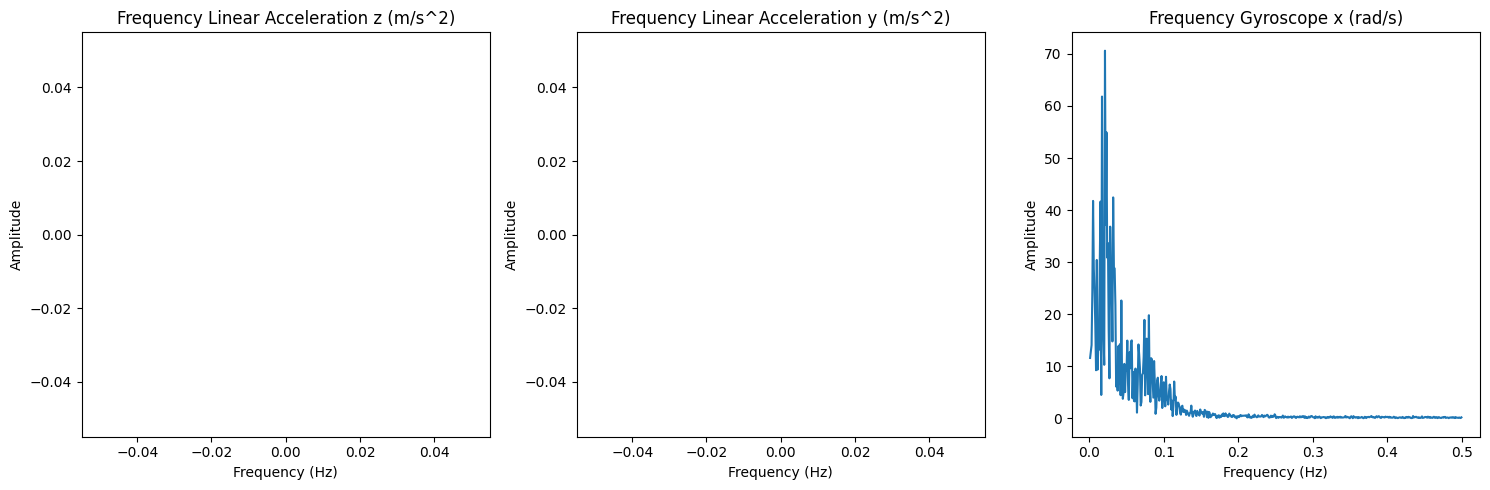

In [287]:
plot_frequencies(squat_df)

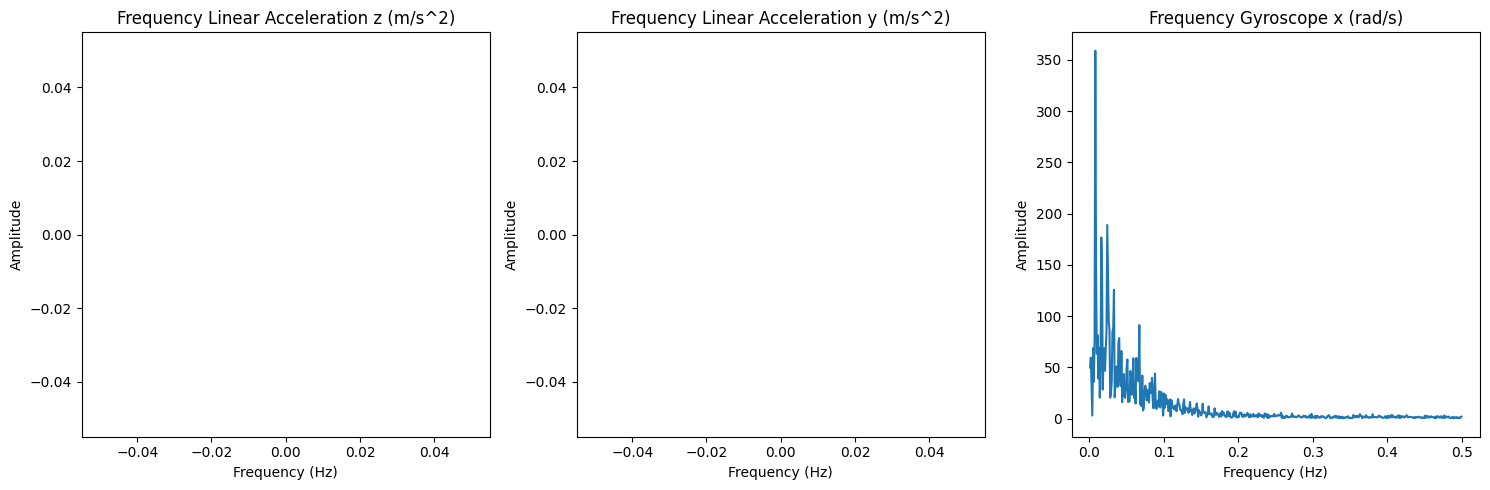

In [288]:
plot_frequencies(jump_df)

### Filtern der Frequenzen

In den Plots ist erkennbar, dass der Großteil der Daten sich im Bereich bis 0,3 Hz befindet. Dies deutet darauf hin, dass 
die wesentlichen Bewegungsinformationen für Aktivitäten wie Kniebeugen und Sprünge in diesem niedrigen Frequenzbereich liegen.
Bei Kniebeugen und Sprüngen handelt es sich um relativ langsame Bewegungen, die durch größere, kontrollierte Muskelbewegungen
gekennzeichnet sind, im Gegensatz zu schnellen, feinen Bewegungen. Die niedrigeren Frequenzen repräsentieren diese langsameren,
großformatigen Bewegungen besser, während höhere Frequenzen tendenziell schnelle, kleine oder zufällige Bewegungen darstellen,
die möglicherweise als Rauschen betrachtet werden können.

In [289]:
def filter_frequency(dataframe):
    # Kopie des DataFrames erstellen
    filtered_dataframe = dataframe.copy()

    # Festlegen der Cutoff-Frequenz und der Filterordnung
    filter_order = 4 
    high_cutoff = 0.3

    # Butterworth Hochpassfilter erstellen
    b, a = butter(filter_order, high_cutoff, btype='high', analog=False, fs=100)

    # Schleife über alle Spalten außer 'Time (s)'
    for column in dataframe.columns:
        if column != 'Time (s)':
            # Hochpassfilter auf die Signalreihe anwenden
            filtered_signal = filtfilt(b, a, dataframe[column])
            filtered_dataframe[column] = filtered_signal

    return filtered_dataframe

In [290]:
filtered_df_sq = filter_frequency(squat_df)

In [291]:
filtered_df_j = filter_frequency(jump_df)

In [292]:
def plot_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [293]:
def plot_normal_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Y'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Z'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Gyr_X'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

In [294]:
plot_df(filtered_df_j)

In [295]:
plot_df(filtered_df_sq)

In [296]:
filtered_df_j_z = filtered_df_j.copy()
# Korrekte Spaltennamen verwenden
filtered_df_j_z['Z_Score_Y'] = stats.zscore(filtered_df_j['Linear Acceleration y (m/s^2)'])
filtered_df_j_z['Z_Score_Z'] = stats.zscore(filtered_df_j['Linear Acceleration z (m/s^2)'])
filtered_df_j_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_j['Gyroscope x (rad/s)']) 
print(filtered_df_j_z.head())

# Schwellenwert definieren
z_score_threshold = 3

# Ausreißer filtern
filtered_df_j_z = filtered_df_j_z[(abs(filtered_df_j_z['Z_Score_Gyr_X']) <= z_score_threshold) &
                                  (abs(filtered_df_j_z['Z_Score_Y']) <= z_score_threshold) &
                                  (abs(filtered_df_j_z['Z_Score_Z']) <= z_score_threshold)]


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.034933                            NaN                            NaN   
1  0.043438                            NaN                            NaN   
2  0.053438                            NaN                            NaN   
3  0.063438                            NaN                            NaN   
4  0.073438                            NaN                            NaN   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  
0             0.075573        NaN        NaN       0.061156  
1             0.116436        NaN        NaN       0.103764  
2             0.166927        NaN        NaN       0.156411  
3             0.199557        NaN        NaN       0.190435  
4             0.205012        NaN        NaN       0.196124  


In [297]:
filtered_df_sq_z = filtered_df_sq.copy()
# Korrekte Spaltennamen verwenden
filtered_df_sq_z['Z_Score_Y'] = stats.zscore(filtered_df_sq['Linear Acceleration y (m/s^2)'])
filtered_df_sq_z['Z_Score_Z'] = stats.zscore(filtered_df_sq['Linear Acceleration z (m/s^2)'])
filtered_df_sq_z['Z_Score_Gyr_X'] = stats.zscore(filtered_df_sq['Gyroscope x (rad/s)']) 
print(filtered_df_sq_z.head())

# Schwellenwert definieren
z_score_threshold = 3

# Ausreißer filtern
filtered_df_sq_z = filtered_df_sq_z[(abs(filtered_df_sq_z['Z_Score_Gyr_X']) <= z_score_threshold) &
                                  (abs(filtered_df_sq_z['Z_Score_Y']) <= z_score_threshold) &
                                  (abs(filtered_df_sq_z['Z_Score_Z']) <= z_score_threshold)]


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.030261                            NaN                            NaN   
1  0.040261                            NaN                            NaN   
2  0.050261                            NaN                            NaN   
3  0.060261                            NaN                            NaN   
4  0.070261                            NaN                            NaN   

   Gyroscope x (rad/s)  Z_Score_Y  Z_Score_Z  Z_Score_Gyr_X  
0            -0.067891        NaN        NaN      -0.251284  
1            -0.079609        NaN        NaN      -0.292424  
2            -0.094844        NaN        NaN      -0.345907  
3            -0.102752        NaN        NaN      -0.373669  
4            -0.111885        NaN        NaN      -0.405733  


Außreißer gefiltert

In [298]:
plot_normal_df(filtered_df_j_z)

In [299]:
plot_df(filtered_df_sq_z)

Normalisieren

In [300]:
plot_normal_df(filtered_df_sq_z)

In [301]:
plot_normal_df(filtered_df_j_z)

In [302]:
filtered_df_sq['Label'] = 'squat'
filtered_df_j['Label'] = 'jump'
combined_df = pd.concat([filtered_df_sq, filtered_df_j], ignore_index=True)

In [303]:
combined_df.head()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s),Label
0,0.030261,NaN,NaN,-0.067891,squat
1,0.040261,NaN,NaN,-0.079609,squat
2,0.050261,NaN,NaN,-0.094844,squat
3,0.060261,NaN,NaN,-0.102752,squat
4,0.070261,NaN,NaN,-0.111885,squat


In [304]:
window_size = 80 #Bei Bedarf anpassen
overlap = 50 #Bei Bedarf anpassen

#Liste initiieren für Fenster
windows = []

#Für jedes Fenster in den Daten neuen Dataframe erstellen, der in Liste abgelegt wird 
for i in range(0, len(combined_df), window_size - overlap):
    window = combined_df.iloc[i:i+window_size]
    windows.append(window)

#Ersten Dataframe in der Liste ausgeben lassen 
print(windows[0].head())
#Anzahl Datenpunkte des ersten Dataframes ausgeben lassen 
print(len(windows[0]))
#Spalten des ersten Dataframes ausgeben lassen 
#print(windows[0].columns)

#Ausgeben lassen wie viele Dataframes also Fenster entstanden sind 
print (len(windows))


   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.030261                            NaN                            NaN   
1  0.040261                            NaN                            NaN   
2  0.050261                            NaN                            NaN   
3  0.060261                            NaN                            NaN   
4  0.070261                            NaN                            NaN   

   Gyroscope x (rad/s)  Label  
0            -0.067891  squat  
1            -0.079609  squat  
2            -0.094844  squat  
3            -0.102752  squat  
4            -0.111885  squat  
80
67


In [305]:
windows[0].head()

,Time (s),Linear Acceleration z (m/s^2),Linear Acceleration y (m/s^2),Gyroscope x (rad/s),Label
0,0.030261,NaN,NaN,-0.067891,squat
1,0.040261,NaN,NaN,-0.079609,squat
2,0.050261,NaN,NaN,-0.094844,squat
3,0.060261,NaN,NaN,-0.102752,squat
4,0.070261,NaN,NaN,-0.111885,squat


In [306]:
import numpy as np
import pandas as pd

# Leere Liste erstellen, um Features zu speichern
feature_list = []

# Jeden DataFrame in windows einzeln durchgehen und für jede der drei Achsen die Features berechnen
for window in windows:
    acc_y = window['Linear Acceleration y (m/s^2)']
    acc_z = window['Linear Acceleration z (m/s^2)']
    gyro_x = window['Gyroscope x (rad/s)']

    # Berechnete Werte an Liste anhängen, unter entsprechend benannten Spalten
    features = {
        'acc_y_peak': acc_y.max(),
        'acc_y_std_dev': acc_y.std(),
        'acc_y_variance': acc_y.var(),
        'acc_y_signal_energy': np.sum(acc_y**2),
        'acc_z_peak': acc_z.max(),
        'acc_z_std_dev': acc_z.std(),
        'acc_z_variance': acc_z.var(),
        'acc_z_signal_energy': np.sum(acc_z**2),
        'gyro_x_peak': gyro_x.max(),
        'gyro_x_std_dev': gyro_x.std(),
        'gyro_x_variance': gyro_x.var(),
        'gyro_x_signal_energy': np.sum(gyro_x**2)
    }
    feature_list.append(features)

feature_df = pd.DataFrame(feature_list)

print(feature_df.head())


   acc_y_peak  acc_y_std_dev  acc_y_variance  acc_y_signal_energy  acc_z_peak  \
0         NaN            NaN             NaN                  0.0         NaN   
1         NaN            NaN             NaN                  0.0         NaN   
2         NaN            NaN             NaN                  0.0         NaN   
3         NaN            NaN             NaN                  0.0         NaN   
4         NaN            NaN             NaN                  0.0         NaN   

   acc_z_std_dev  acc_z_variance  acc_z_signal_energy  gyro_x_peak  \
0            NaN             NaN                  0.0     0.420565   
1            NaN             NaN                  0.0     0.873841   
2            NaN             NaN                  0.0     0.873841   
3            NaN             NaN                  0.0     0.641863   
4            NaN             NaN                  0.0     0.641863   

   gyro_x_std_dev  gyro_x_variance  gyro_x_signal_energy  
0        0.149352         0.02230

Clustering

In [307]:
from sklearn.cluster import KMeans

# Anzahl der gewünschten Cluster festlegen 
anzahl_cluster = 2  # Passe dies an deine Anforderungen an.

# Initialisierung des K-Means-Cluster-Algorithmus
kmeans = KMeans(n_clusters=anzahl_cluster, random_state=0)

# Clustering auf den Daten in 'feature_df' durchführen
cluster_labels = kmeans.fit_predict(feature_df)

# Berechnete Cluster zu jedem der Datenpunkte im Feature Dataframe zuordnungen
feature_df['Cluster'] = cluster_labels

# Gib das aktualisierte DataFrame mit Clusterzuordnungen aus.
#print(feature_df.head())
feature_df.columns


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

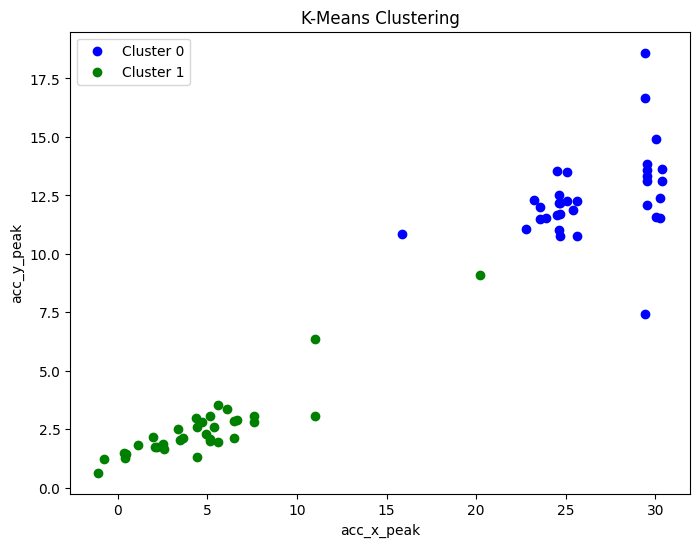

In [ ]:
# Visualisierung der Cluster
plt.figure(figsize=(8, 6))

# Erstelle eine Liste von Farben für die Cluster
farben = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Durchlaufen der Cluster und erstellen der Scatter-Plots für jeden Cluster
for cluster_id in range(anzahl_cluster):
    cluster_data = feature_df[feature_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['acc_y_peak'], cluster_data['acc_y_std_dev'], c=farben[cluster_id], label=f'Cluster {cluster_id}')
# Beschriftung des Diagramms
plt.xlabel('acc_x_peak')
plt.ylabel('acc_y_peak')
plt.title('K-Means Clustering')
plt.legend()

# Anzeigen des Scatter-Plots
plt.show()
